Using device: mps
Training network k=1, time = 0.100
  Epoch 200, Loss = 1.86295e-04
  Epoch 400, Loss = 9.84986e-05
  Epoch 600, Loss = 3.90436e-05
  Epoch 800, Loss = 1.53133e-04
  Epoch 1000, Loss = 8.54094e-05
Training network k=2, time = 0.200
  Epoch 200, Loss = 1.57837e-04
  Epoch 400, Loss = 1.34457e-04
  Epoch 600, Loss = 8.18023e-05
  Epoch 800, Loss = 7.93559e-05
  Epoch 1000, Loss = 7.05497e-05
Training network k=3, time = 0.300
  Epoch 200, Loss = 1.68985e-04
  Epoch 400, Loss = 1.51589e-04
  Epoch 600, Loss = 1.26095e-04
  Epoch 800, Loss = 9.63867e-05
  Epoch 1000, Loss = 9.42030e-05
Training network k=4, time = 0.400
  Epoch 200, Loss = 9.20997e-05
  Epoch 400, Loss = 6.70273e-05
  Epoch 600, Loss = 5.04908e-05
  Epoch 800, Loss = 4.50665e-05
  Epoch 1000, Loss = 5.15808e-05
Training network k=5, time = 0.500
  Epoch 200, Loss = 6.33968e-05
  Epoch 400, Loss = 3.43284e-05
  Epoch 600, Loss = 3.59967e-05
  Epoch 800, Loss = 4.22642e-05
  Epoch 1000, Loss = 2.83296e-05
Tr

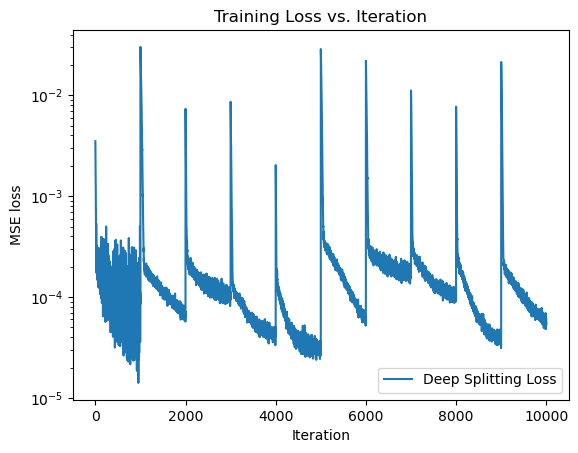

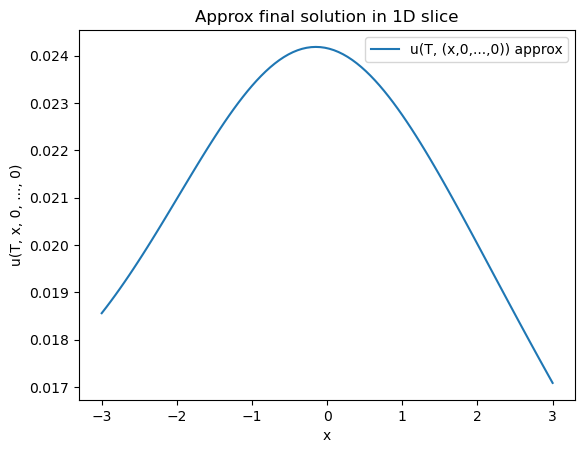

Done! Saved predictions in dsm_approx_solutions.json


In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
device = None

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    device = torch.device("cpu")
else:
    device = torch.device("mps")
print("device: ", device)
#======================================================================
#======================================================================


#-------------------------------------------------
#             Hyperparameters
#-------------------------------------------------
pde_dimension = 10      # dimension of x
alpha         = 1.0     # fractional exponent
T             = 1.0     # final time
N_time_steps  = 10      # number of time splits
batch_size    = 1024    # batch size for Monte Carlo
lr_per_step   = 1e-3    # learning rate for each step
epochs_per_step = 1000  # how many epochs to train each time-step network
hidden_width  = 64      # width of hidden layers




# Generate alpha-stable increments in 10D
# (For alpha=1, we do Cauchy(0, dt^(1/alpha))
# For alpha=2, standard normal with scale sqrt(dt)
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Return shape (batch_size, dim) of i.i.d. alpha-stable increments
    with 'time step' dt.  For demonstration, we implement:
       alpha=2.0 -> Gaussian with variance = 2 * dt   (symmetric stable)
       alpha=1.0 -> Cauchy(0, dt)
    """
    if alpha == 2.0:
        # Symmetric alpha-stable with alpha=2 is just Brownian motion,
        # so increments ~ Normal(0, sqrt(2*dt))
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        # Symmetric Cauchy(0, scale=dt).  PyTorch has no built-in Cauchy
        # prior to 1.13, so its dine via the StudentT with 1 degree
        # of freedom
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1 or alpha=2 here.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    # x shape = (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# store N+1 networks: net[0]..net[N].
# net[0] is just the known initial condition (can code as a function)
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)


nets = [None]*(N_time_steps+1)

# net[0]: the exact init condition, stored as a Python lambda
nets[0] = initial_condition

# net[k]: MLP for u(t_k, x)
for k in range(1, N_time_steps+1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# Training Loop for Deep Splitting
# time steps k = 0..N-1, to get net[k+1].
# At each step, net[k+1](x) ~ E[ net[k](x + Y) ].
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1)  # e.g. 0,0.1,...,1.0
dt = float(T / N_time_steps)

# To track of losses for visualization
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # 1) sample x ~ Normal(0,1) for 10D (or another distribution)
        x_batch = torch.randn(batch_size, pde_dimension, device=device)

        # 2) sample M alpha-stable increments (e.g. just 1 per x in this code).
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        # 3) Evaluate the "previous" net at x+Y
        #    net[k] might be a function (k=0) or an MLP (k>0).
        if k == 0:
            # net[0] is the known initial condition function
            u_prev = nets[k](x_batch + Y)  # call initial_condition
        else:
            u_prev = nets[k](x_batch + Y)

        u_target = u_prev.detach()  # previous net's value is considered as "target"

        # Evaluate the new net
        u_new = nets[k+1](x_batch)

        # 5) MSE loss
        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch+1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")


# Plot the loss curve
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration (Deep Splitting)")
plt.legend()
plt.show()


def evaluate_final_net_1d_slice(x_vals_1d):
    """
    Evaluate the final net at x = (x1, 0,0,...,0).
    We'll see if it decays with |x|.
    """
    # net[T] is nets[N_time_steps]
    x_tensor = torch.zeros((len(x_vals_1d), pde_dimension))
    x_tensor[:,0] = torch.tensor(x_vals_1d)
    x_tensor = x_tensor.to(device)

    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor).cpu().numpy().ravel()
    return u_approx

x_range = np.linspace(-3, 3, 100)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, (x,0,...,0)) approx")
plt.title("Approx final solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()


device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 1.25492e-04
  Epoch 400, Loss = 1.88901e-04
  Epoch 600, Loss = 1.48324e-04
  Epoch 800, Loss = 2.46514e-04
  Epoch 1000, Loss = 6.49395e-05
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 5.96580e-05
  Epoch 400, Loss = 6.22206e-05
  Epoch 600, Loss = 6.20207e-05
  Epoch 800, Loss = 6.30917e-05
  Epoch 1000, Loss = 5.62431e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 3.78791e-05
  Epoch 400, Loss = 2.78081e-05
  Epoch 600, Loss = 2.93354e-05
  Epoch 800, Loss = 3.07547e-05
  Epoch 1000, Loss = 2.78370e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.19550e-05
  Epoch 400, Loss = 1.68562e-05
  Epoch 600, Loss = 1.54750e-05
  Epoch 800, Loss = 1.57712e-05
  Epoch 1000, Loss = 1.22397e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 2.02828e-05
  Epoch 400, Loss = 1.31000e-05
  Epoch 600, Loss = 1.38445e-05
  Epoch 800, Loss = 9.45030e-06
  Epo

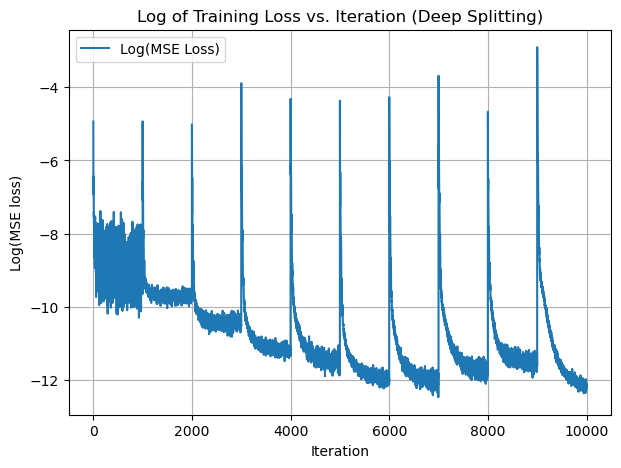

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("device: ", device)

#-------------------------------------------------
#             Hyperparameters
#-------------------------------------------------
pde_dimension = 10
alpha = 1.0
T = 1.0
N_time_steps = 10
batch_size = 1024
lr_per_step = 1e-3
epochs_per_step = 1000
hidden_width = 64

#-------------------------------------------------
# Sample alpha-stable increments
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    if alpha == 2.0:
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("alpha=1 or 2 only.")

#-------------------------------------------------
# Initial Condition
#-------------------------------------------------
def initial_condition(x):
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# MLP Definition
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

#-------------------------------------------------
# Initialize Networks
#-------------------------------------------------
nets = [None] * (N_time_steps + 1)
nets[0] = initial_condition
for k in range(1, N_time_steps + 1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# Training Loop
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps + 1)
dt = float(T / N_time_steps)
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        x_batch = torch.randn(batch_size, pde_dimension, device=device)
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        if k == 0:
            u_prev = nets[k](x_batch + Y)
        else:
            u_prev = nets[k](x_batch + Y)

        u_target = u_prev.detach()
        u_new = nets[k+1](x_batch)

        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# Plot Log of Loss
#-------------------------------------------------
log_losses = np.log(training_losses)

plt.figure(figsize=(7, 5))
plt.plot(log_losses, label="Log(MSE Loss)")
plt.xlabel("Iteration")
plt.ylabel("Log(MSE loss)")
plt.title("Log of Training Loss vs. Iteration (Deep Splitting)")
plt.legend()
plt.grid(True)
plt.savefig("deep_splitting_log_loss.png", dpi=300, bbox_inches='tight')
plt.show()



device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 1.36974e-04
  Epoch 400, Loss = 1.18619e-04
  Epoch 600, Loss = 1.76618e-04
  Epoch 800, Loss = 6.24879e-05
  Epoch 1000, Loss = 5.61674e-05
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 5.78363e-05
  Epoch 400, Loss = 5.73335e-05
  Epoch 600, Loss = 5.54158e-05
  Epoch 800, Loss = 5.80606e-05
  Epoch 1000, Loss = 6.50929e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 5.53241e-05
  Epoch 400, Loss = 2.78211e-05
  Epoch 600, Loss = 2.18573e-05
  Epoch 800, Loss = 1.78690e-05
  Epoch 1000, Loss = 2.04322e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.80220e-05
  Epoch 400, Loss = 2.36553e-05
  Epoch 600, Loss = 2.71229e-05
  Epoch 800, Loss = 2.56808e-05
  Epoch 1000, Loss = 2.68194e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 1.00467e-05
  Epoch 400, Loss = 9.17481e-06
  Epoch 600, Loss = 7.93237e-06
  Epoch 800, Loss = 8.33534e-06
  Epo

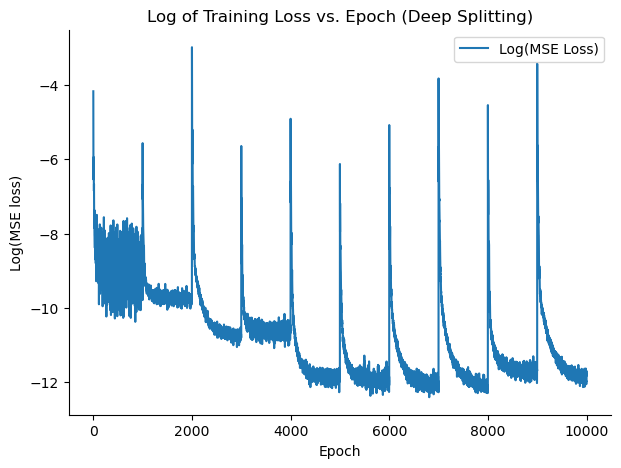

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("device: ", device)

#-------------------------------------------------
#             Hyperparameters
#-------------------------------------------------
pde_dimension = 10
alpha = 1.0
T = 1.0
N_time_steps = 10
batch_size = 1024
lr_per_step = 1e-3
epochs_per_step = 1000
hidden_width = 64

#-------------------------------------------------
# Sample alpha-stable increments
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    if alpha == 2.0:
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("alpha=1 or 2 only.")

#-------------------------------------------------
# Initial Condition
#-------------------------------------------------
def initial_condition(x):
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# MLP Definition
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

#-------------------------------------------------
# Initialize Networks
#-------------------------------------------------
nets = [None] * (N_time_steps + 1)
nets[0] = initial_condition
for k in range(1, N_time_steps + 1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# Training Loop
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps + 1)
dt = float(T / N_time_steps)
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        x_batch = torch.randn(batch_size, pde_dimension, device=device)
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        if k == 0:
            u_prev = nets[k](x_batch + Y)
        else:
            u_prev = nets[k](x_batch + Y)

        u_target = u_prev.detach()
        u_new = nets[k+1](x_batch)

        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# Plot Log of Loss (Cleaned up)
#-------------------------------------------------
log_losses = np.log(training_losses)

plt.figure(figsize=(7, 5))
plt.plot(log_losses, label="Log(MSE Loss)")
plt.xlabel("Epoch")
plt.ylabel("Log(MSE loss)")
plt.title("Log of Training Loss vs. Epoch (Deep Splitting)")
plt.legend()

# Clean style: no grid lines, remove top/right spines
plt.grid(False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Save cleaned plot
plt.savefig("deep_splitting_log_loss_clean.png", dpi=300, bbox_inches='tight')
plt.show()


device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 1.45692e-04
  Epoch 400, Loss = 1.46597e-04
  Epoch 600, Loss = 1.08344e-04
  Epoch 800, Loss = 1.01749e-04
  Epoch 1000, Loss = 1.61665e-04
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 6.14033e-05
  Epoch 400, Loss = 6.93536e-05
  Epoch 600, Loss = 6.96829e-05
  Epoch 800, Loss = 6.94007e-05
  Epoch 1000, Loss = 6.71357e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 4.61526e-05
  Epoch 400, Loss = 4.11575e-05
  Epoch 600, Loss = 3.86392e-05
  Epoch 800, Loss = 3.56110e-05
  Epoch 1000, Loss = 4.32179e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.22512e-05
  Epoch 400, Loss = 1.99368e-05
  Epoch 600, Loss = 1.80282e-05
  Epoch 800, Loss = 1.85786e-05
  Epoch 1000, Loss = 1.55637e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 2.73656e-05
  Epoch 400, Loss = 1.37323e-05
  Epoch 600, Loss = 1.32101e-05
  Epoch 800, Loss = 1.10533e-05
  Epo

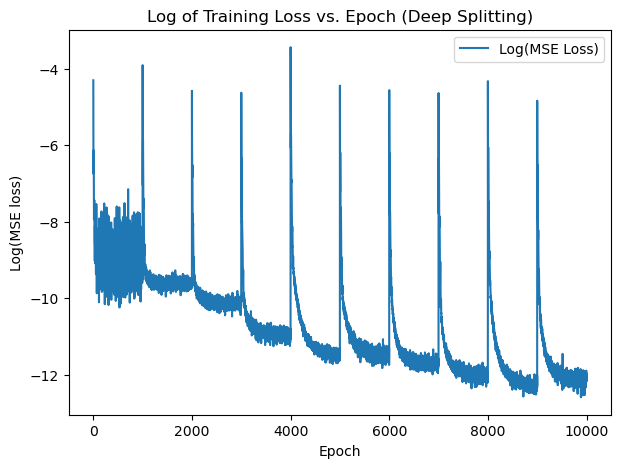

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("device: ", device)

#-------------------------------------------------
#             Hyperparameters
#-------------------------------------------------
pde_dimension = 10
alpha = 1.0
T = 1.0
N_time_steps = 10
batch_size = 1024
lr_per_step = 1e-3
epochs_per_step = 1000
hidden_width = 64

#-------------------------------------------------
# Sample alpha-stable increments
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    if alpha == 2.0:
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("alpha=1 or 2 only.")

#-------------------------------------------------
# Initial Condition
#-------------------------------------------------
def initial_condition(x):
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# MLP Definition
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

#-------------------------------------------------
# Initialize Networks
#-------------------------------------------------
nets = [None] * (N_time_steps + 1)
nets[0] = initial_condition
for k in range(1, N_time_steps + 1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# Training Loop
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps + 1)
dt = float(T / N_time_steps)
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        x_batch = torch.randn(batch_size, pde_dimension, device=device)
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        if k == 0:
            u_prev = nets[k](x_batch + Y)
        else:
            u_prev = nets[k](x_batch + Y)

        u_target = u_prev.detach()
        u_new = nets[k+1](x_batch)

        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# Plot Log of Loss (Clean, all borders visible)
#-------------------------------------------------
log_losses = np.log(training_losses)

plt.figure(figsize=(7, 5))
plt.plot(log_losses, label="Log(MSE Loss)")
plt.xlabel("Epoch")
plt.ylabel("Log(MSE loss)")
plt.title("Log of Training Loss vs. Epoch (Deep Splitting)")
plt.legend()

# Remove grid, keep all axis borders
plt.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(True)

# Save the figure
plt.savefig("deep_splitting_log_loss_clean.png", dpi=300, bbox_inches='tight')
plt.show()
